<a href="https://colab.research.google.com/github/Felipe-DelosSantos09/Diplomado-IA/blob/master/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de strawberries

link del dataset: https://universe.roboflow.com/saruta-nonthasiriwat-sr2y9/strawberry-tyqqb/dataset/2

Link interesante, datos de paga:  https://www.kaggle.com/datasets/trainingdatapro/ripe-strawberries-detection/data

Mas imagenes, no revisadas: https://universe.roboflow.com/cs2/farm-detect9/dataset/3

In [1]:
# Uso de la API de roboflow
%pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


## Descargar el dataset


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="MsuoDVda6oLsTGxghLi6")
project = rf.workspace("diplomadoia").project("proyecto_final-pwtiq")
version = project.version(1)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Proyecto_final-1 in yolov5pytorch:: 100%|██████████| 1390/1390 [00:00<00:00, 2687.75it/s]


## Visualización de los datos

In [3]:
# Codigo utilizable como libreria
import os
import yaml
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import shutil

def load_yaml_config(yaml_path):
    """
    Carga un archivo de configuración YAML.

    Args:
        yaml_path (str): Ruta al archivo YAML.

    Returns:
        dict: Contenido del YAML parseado.
    """
    with open(yaml_path, 'r') as file:
        return yaml.safe_load(file)

def count_classes(labels_dir):
    """
    Cuenta las ocurrencias de cada clase en los archivos de etiquetas de un directorio dado.

    Args:
        labels_dir (str): Ruta al directorio que contiene los archivos de etiquetas.

    Returns:
        Counter: Un objeto Counter con los conteos de clases.
    """
    class_counter = Counter()
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    return class_counter

def analyze_class_balance(config_path):
    """
    Analiza el balance de clases en el conjunto de datos según lo especificado en el archivo de configuración.

    Args:
        config_path (str): Ruta al archivo de configuración YAML.

    Returns:
        pd.DataFrame: DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    config = load_yaml_config(config_path)
    classes = config['names']
    datasets = ['train', 'valid', 'test']
    base_dir = os.path.dirname(config_path)

    results = {}
    for dataset in datasets:
        labels_dir = os.path.join(base_dir, dataset, 'labels')
        if os.path.exists(labels_dir):
            results[dataset] = count_classes(labels_dir)
        else:
            print(f"Advertencia: El directorio '{labels_dir}' no existe. Saltando el conjunto de datos {dataset}.")
            results[dataset] = Counter()

    # Creación del DataFrame
    df = pd.DataFrame({dataset: [results[dataset].get(i, 0) for i in range(len(classes))] for dataset in datasets}, index=classes)

    return df


def plot_class_balance(df):
    """
    Genera un gráfico de barras para visualizar el balance de clases en los diferentes conjuntos de datos.

    Args:
        df (pd.DataFrame): DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    ax = df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Balance de Clases en los Conjuntos de Datos')
    plt.xlabel('Clases')
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.legend(title='Conjuntos de Datos')
    plt.tight_layout()
    plt.show()


def remove_directory_if_exists(directory_path):
    """
    Elimina un directorio si existe.

    Args:
        directory_path (str): La ruta del directorio a eliminar.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directorio '{directory_path}' eliminado exitosamente.")
    else:
        print(f"Directorio '{directory_path}' no existe.")

**NOTA: Es necesario que el dataset se encuentre en el siguiente formato.**


```plaintext
strawberry-2
├── test
├── train
├── valid
└── data.yaml
```



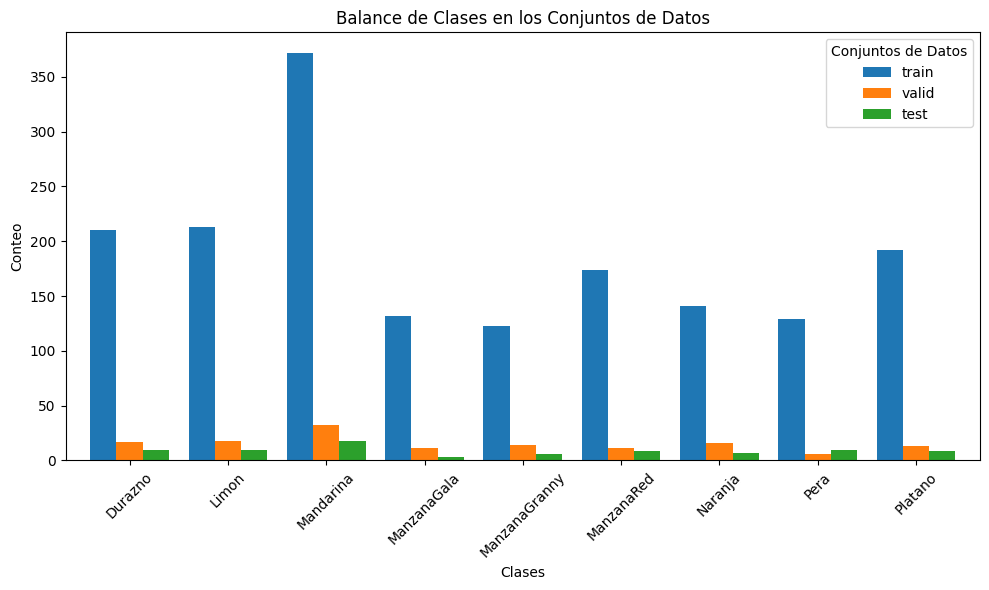

               train  valid  test
Durazno          210     17    10
Limon            213     18    10
Mandarina        372     32    18
ManzanaGala      132     11     3
ManzanaGranny    123     14     6
ManzanaRed       174     11     9
Naranja          141     16     7
Pera             129      6    10
Platano          192     13     9


In [4]:
class_balance_df = analyze_class_balance(r'/content/Proyecto_final-1/data.yaml')
plot_class_balance(class_balance_df)
print(class_balance_df)

# Instalación de Ultralytics

In [5]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [6]:
import yaml

# Definir el contenido del archivo YAML
data = {
    'names': ['Durazno','Limon','Mandarina','ManzanaGala','ManzanaGranny','ManzanaRed','Naranja','Pera','Platano'],
    'nc': 9,
    'test': '/content/Proyecto_final-1/test',
    'train': '/content/Proyecto_final-1/train',
    'val': '/content/Proyecto_final-1/valid'
}

path = r'/content/Proyecto_final-1/data.yaml'

# Escribir el contenido en un archivo YAML
with open(path , 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("Archivo data.yaml creado exitosamente.")


Archivo data.yaml creado exitosamente.


Descripción de la Arquitectura: https://docs.ultralytics.com/yolov5/tutorials/architecture_description/

In [ ]:
#remove_directory_if_exists(r'D:\Diplomado-IA\Modulo_5_extendido\Proyecto_1\runs')

In [7]:
from ultralytics import YOLO

model = YOLO("yolov5s.pt")  # Entrenamiento con pesos pre-entrenados

#model = YOLO("yolov5s.yaml") # Entrenamiento desde cero, revisar los modelos en https://docs.ultralytics.com/models/yolov5/#supported-tasks-and-modes
# NOTA: Yolov5su  has moved towards an anchor-free, objectness-free approach. Sin embargo los detalles arquitectonicos son no cambian, solo el cabezal de detección

model.train(
    data=r'/content/Proyecto_final-1/data.yaml',
    task="detect",
    mode='train',
    epochs=20,          # Número de épocas de entrenamiento
    patience=100,       # Paciencia para el early stopping
    batch=16,           # Tamaño del batch
    imgsz=640,          # Tamaño de la imagen
    save=True,          # Guardar el modelo después de entrenar
    cache=False,        # Usar caché de datos
    device=None,        # Dispositivo para el entrenamiento (None para auto-detectar)
    workers=8,          # Número de workers para el data loading
    pretrained=True,    # Usar pesos pre-entrenados
    optimizer='auto',   # Optimizador
    verbose=True,       # Imprimir información durante el entrenamiento
    seed=0,             # Semilla para la reproducibilidad
    deterministic=True, # Asegurar entrenamiento determinista
    amp=True,           # Mixed precision training
    val=True,           # Validar después de cada época
    split='val',        # División para validación
    iou=0.7,            # Umbral de IoU
    max_det=300,        # Máximo número de detecciones por imagen
    lr0=0.01,           # Tasa de aprendizaje inicial
    lrf=0.01,           # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,     # Momento para SGD
    weight_decay=0.0005,# Decaimiento de peso
    warmup_epochs=3.0,  # Número de épocas de calentamiento
    warmup_momentum=0.8,# Momento durante el calentamiento
    warmup_bias_lr=0.1, # Tasa de aprendizaje para el sesgo durante el calentamiento
    box=7.5,            # Pérdida de la caja
    cls=0.5,            # Pérdida de la clase
    dfl=1.5,            # Pérdida de distribución focal
    mosaic=1.0,         # Probabilidad de aplicar la técnica de mosaic
    auto_augment='randaugment', # Tipo de aumento automático
    erasing=0.4,        # Probabilidad de borrado aleatorio
    save_dir='runs/detect/train', # Directorio para guardar los resultados
    name = 'exp-1'
)


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 292MB/s]


Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/Proyecto_final-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=exp-1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 99.1MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 311MB/s]


AMP: checks passed ✅


train: Scanning /content/Proyecto_final-1/train/labels... 606 images, 0 backgrounds, 0 corrupt: 100%|██████████| 606/606 [00:00<00:00, 734.74it/s]

train: New cache created: /content/Proyecto_final-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Proyecto_final-1/valid/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 443.13it/s]

val: New cache created: /content/Proyecto_final-1/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 138. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/exp-1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/exp-1
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.03G      1.424      2.729      1.633         90        640: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         55        138      0.485      0.607      0.537      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.96G      1.251      1.588      1.395         57        640: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         55        138      0.628      0.723      0.729      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.95G      1.235      1.372      1.384         70        640: 100%|██████████| 38/38 [00:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         55        138      0.627      0.716      0.716      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.95G      1.225      1.243      1.376         78        640: 100%|██████████| 38/38 [00:14<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         55        138      0.695      0.706      0.768      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.91G      1.206      1.208      1.387         61        640: 100%|██████████| 38/38 [00:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         55        138      0.743      0.784       0.78      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.96G      1.154      1.077      1.339         69        640: 100%|██████████| 38/38 [00:12<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         55        138      0.805      0.805      0.824      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.93G      1.157      1.091      1.346         67        640: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         55        138       0.72      0.762      0.782      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.95G       1.09       1.01      1.286         61        640: 100%|██████████| 38/38 [00:12<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         55        138      0.718      0.849      0.822      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.93G      1.102     0.9446      1.296         49        640: 100%|██████████| 38/38 [00:13<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         55        138      0.834      0.841      0.878      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.95G      1.041     0.8856      1.262        104        640: 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         55        138      0.777       0.69      0.779      0.572


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.91G     0.9891     0.7881      1.249         39        640: 100%|██████████| 38/38 [00:16<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         55        138      0.831      0.849      0.845      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.93G     0.9567     0.7179      1.225         38        640: 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         55        138       0.78      0.869      0.855      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.92G     0.9193     0.6624      1.207         26        640: 100%|██████████| 38/38 [00:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         55        138      0.759      0.895      0.861      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.92G     0.9072     0.6179      1.207         44        640: 100%|██████████| 38/38 [00:12<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         55        138      0.862      0.848       0.87      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.91G     0.8738     0.5945      1.172         28        640: 100%|██████████| 38/38 [00:11<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         55        138      0.813      0.887      0.867      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.93G     0.8843     0.5608      1.168         42        640: 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         55        138      0.817      0.877      0.862      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.91G     0.8523     0.5224      1.156         39        640: 100%|██████████| 38/38 [00:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         55        138       0.85      0.873      0.876      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.92G      0.799     0.4993      1.128         37        640: 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         55        138      0.877      0.861       0.89      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.91G     0.7743     0.4794      1.105         47        640: 100%|██████████| 38/38 [00:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         55        138      0.869      0.897      0.892      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.93G     0.7483     0.4532      1.096         40        640: 100%|██████████| 38/38 [00:12<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         55        138      0.867      0.894       0.89       0.69



20 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/exp-1/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/exp-1/weights/best.pt, 18.5MB

Validating runs/detect/exp-1/weights/best.pt...
Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5s summary (fused): 193 layers, 9,115,019 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


                   all         55        138      0.869      0.897      0.892      0.698
               Durazno         17         17      0.904      0.824       0.83      0.635
                 Limon         17         18      0.883      0.833      0.922      0.671
             Mandarina         30         32      0.939      0.963      0.959      0.805
           ManzanaGala         11         11      0.833      0.909        0.9      0.729
         ManzanaGranny         14         14      0.954      0.857       0.87      0.781
            ManzanaRed         11         11      0.913      0.953      0.912      0.707
               Naranja         16         16      0.914          1      0.988      0.779
                  Pera          6          6      0.721          1      0.843      0.713
               Platano         13         13       0.76      0.732      0.805      0.461
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec33d08baf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

## Evaluación del modelo entrenado

https://docs.ultralytics.com/modes/val/

In [8]:
metrics = model.val(imgsz = 640, split = 'test', plots = True, name = 'Metrics-test-exp-1')

Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5s summary (fused): 193 layers, 9,115,019 parameters, 0 gradients, 23.8 GFLOPs


val: Scanning /content/Proyecto_final-1/test/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 515.74it/s]

val: New cache created: /content/Proyecto_final-1/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


                   all         28         82       0.89      0.894      0.961      0.757
               Durazno         10         10      0.894        0.7      0.869      0.709
                 Limon         10         10      0.893          1      0.995      0.709
             Mandarina         17         18      0.901      0.833      0.964      0.741
           ManzanaGala          3          3      0.572          1      0.995      0.667
         ManzanaGranny          6          6      0.936      0.833      0.922      0.849
            ManzanaRed          9          9      0.965      0.889      0.984      0.814
               Naranja          7          7      0.856          1       0.96      0.743
                  Pera         10         10      0.998        0.9      0.986      0.777
               Platano          9          9      0.997      0.889      0.975        0.8
Speed: 0.4ms preprocess, 23.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detec

In [9]:
metrics = model.val(imgsz = 640, split = 'val', plots = True, name = 'Metrics-val-exp-1')

Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Proyecto_final-1/valid/labels.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3, len(boxes) = 138. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


                   all         55        138      0.869      0.897      0.892      0.696
               Durazno         17         17      0.904      0.824       0.83      0.635
                 Limon         17         18      0.884      0.833      0.922       0.67
             Mandarina         30         32      0.939      0.964      0.959      0.805
           ManzanaGala         11         11      0.833      0.909        0.9      0.729
         ManzanaGranny         14         14      0.954      0.857       0.87      0.781
            ManzanaRed         11         11      0.913      0.953      0.912      0.691
               Naranja         16         16      0.914          1      0.988      0.776
                  Pera          6          6      0.721          1      0.843      0.713
               Platano         13         13       0.76      0.732      0.805      0.461
Speed: 1.7ms preprocess, 35.5ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detec

In [10]:
metrics = model.val(imgsz = 640, split = 'train', plots = True, name = 'Metrics-train-exp-1')

Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Proyecto_final-1/train/labels.cache... 606 images, 0 backgrounds, 0 corrupt: 100%|██████████| 606/606 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.92it/s]


                   all        606       1686      0.984      0.986      0.994      0.827
               Durazno        210        210      0.987      0.981      0.994      0.814
                 Limon        213        213      0.967          1      0.995      0.818
             Mandarina        345        372      0.998      0.992      0.995      0.835
           ManzanaGala        132        132          1      0.972      0.995      0.824
         ManzanaGranny        123        123      0.982      0.976      0.993      0.872
            ManzanaRed        174        174      0.966      0.984      0.994      0.829
               Naranja        138        141          1      0.996      0.995      0.855
                  Pera        129        129      0.975          1      0.994      0.802
               Platano        192        192      0.984      0.976      0.994      0.793
Speed: 0.5ms preprocess, 11.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detec

# Predicciones

In [11]:
from ultralytics import YOLO
model = YOLO(r"/content/runs/detect/exp-1/weights/best.pt")

In [15]:
model.predict(r"/content/Proyecto_final-1/test/images/WIN_20240731_10_13_59_Pro_jpg.rf.ff75e84ff7cfbf438fe95d6375dcdf74.jpg", save=True, imgsz=640, conf=0.88)


image 1/1 /content/Proyecto_final-1/test/images/WIN_20240731_10_13_59_Pro_jpg.rf.ff75e84ff7cfbf438fe95d6375dcdf74.jpg: 640x640 1 Naranja, 1 Pera, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
28 labels saved to runs/detect/predict/labels


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Durazno', 1: 'Limon', 2: 'Mandarina', 3: 'ManzanaGala', 4: 'ManzanaGranny', 5: 'ManzanaRed', 6: 'Naranja', 7: 'Pera', 8: 'Platano'}
 obb: None
 orig_img: array([[[ 79,  91,  93],
         [ 81,  93,  95],
         [ 85,  97,  99],
         ...,
         [ 42,  26,  27],
         [ 47,  27,  26],
         [ 48,  28,  27]],
 
        [[ 82,  94,  96],
         [ 84,  96,  98],
         [ 87,  99, 101],
         ...,
         [ 43,  27,  28],
         [ 48,  28,  27],
         [ 49,  29,  28]],
 
        [[ 85,  97,  99],
         [ 87,  99, 101],
         [ 89, 101, 103],
         ...,
         [ 44,  28,  29],
         [ 49,  29,  28],
         [ 50,  30,  29]],
 
        ...,
 
        [[126, 147, 144],
         [131, 152, 149],
         [136, 157, 154],
         ...,
         [ 96, 112, 111],
         [100, 116, 115],
         [104, 1

In [14]:
model.predict(r"/content/Proyecto_final-1/test/images", save=True, imgsz=640, conf=0.88, save_txt = True, save_conf = False)


image 1/28 /content/Proyecto_final-1/test/images/11_jpeg_jpg.rf.f556717a064a79e4f2608571766d843a.jpg: 640x640 1 Limon, 1 ManzanaRed, 15.1ms
image 2/28 /content/Proyecto_final-1/test/images/35bdfaeb-f23a-4eb4-a8b7-5e1eeda1cef5_11zon_jpg.rf.ae808153fda190ee429072427b705b88.jpg: 640x640 (no detections), 14.9ms
image 3/28 /content/Proyecto_final-1/test/images/66cf615d-8b2a-4315-a7be-2b29861343bc_11zon_jpg.rf.4f21daf4f76fd73689146c01e347d1d5.jpg: 640x640 (no detections), 14.9ms
image 4/28 /content/Proyecto_final-1/test/images/IMG_20240731_100946_jpg.rf.0d2197cc60d519b61911d96aa099b278.jpg: 640x640 1 Mandarina, 14.8ms
image 5/28 /content/Proyecto_final-1/test/images/WIN_20240731_10_10_12_Pro_jpg.rf.e80d8cc75dc267af7b292fd1141c3437.jpg: 640x640 1 Platano, 14.9ms
image 6/28 /content/Proyecto_final-1/test/images/WIN_20240731_10_11_01_Pro_jpg.rf.ce41e45c8263c2380b8cf8ae6633d328.jpg: 640x640 (no detections), 14.8ms
image 7/28 /content/Proyecto_final-1/test/images/WIN_20240731_10_12_00_Pro_jpg.rf

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Durazno', 1: 'Limon', 2: 'Mandarina', 3: 'ManzanaGala', 4: 'ManzanaGranny', 5: 'ManzanaRed', 6: 'Naranja', 7: 'Pera', 8: 'Platano'}
 obb: None
 orig_img: array([[[101, 118, 127],
         [101, 118, 127],
         [101, 118, 127],
         ...,
         [136, 162, 176],
         [135, 161, 175],
         [131, 157, 171]],
 
        [[113, 130, 139],
         [112, 129, 138],
         [111, 128, 137],
         ...,
         [117, 143, 157],
         [120, 146, 160],
         [121, 147, 161]],
 
        [[115, 132, 141],
         [115, 132, 141],
         [113, 130, 139],
         ...,
         [123, 149, 163],
         [127, 153, 167],
         [132, 158, 172]],
 
        ...,
 
        [[120, 101,  96],
         [121, 102,  97],
         [121, 102,  97],
         ...,
         [140, 121, 118],
         [140, 121, 118],
         [130, 1